The two sources we work with are Our World in Data and Google Trends.

The goal is to predict when a covid wave occurs based on Google Trends data.

<span style="font-size:24px">Importing Google Trends keyword data and Official Covid data from OurWorld</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Official COVID-19 Data
covid_data = pd.read_csv('./data/owid-covid-data.csv')

# Google Trends Keywords Data
# Google data always starts on 5th January 2020, is weekly, ends on 17th September 2023
#google_trends = pd.read_csv('./data/google_trends/google_trends.csv', names=['date', 'google_trends'], header=0)
anticorps = pd.read_csv('./data/google_trends/anticorps.csv', names=['date', 'anticorps'], header=0)
port_du_masque = pd.read_csv('./data/google_trends/port_du_masque.csv', names=['date', 'port_du_masque'], header=0)
centre_de_test_covid =  pd.read_csv('./data/google_trends/centre_de_test_covid.csv', names=['date', 'centre_de_test_covid'], header=0)
symptomes_covid = pd.read_csv('./data/google_trends/symptomes_covid.csv', names=['date', 'symptomes_covid'], header=0)

# Using filterwarnings to silent a harmless warning
import warnings
warnings.filterwarnings("ignore")

<span>Narrowing covid data and columns relevant for us and choosing France as a country</span>

In [3]:
# Focusing on France as a 'Developed' country
covid_france = covid_data[covid_data['location'] == "France"]

# Selecting relevant columns
covid_france = covid_france[['date', 'total_cases', 'new_cases', 'new_deaths', 'new_cases_per_million','new_deaths_per_million', 'positive_rate', 
            'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative','excess_mortality', 'excess_mortality_cumulative_per_million']]

# Covid data starts on 3rd January 2020, is daily, ends on 21 September 2023. 
# Restricting timeframe from 2020-01-05 to 2023-09-17
covid_france = covid_france[2:-4]

<span>Creating weekly covid france table.
The reason for this is some of the covid data from Our World in Data was reported only once a week, and on other days of the week it was 0. 
It actually fits nicely with google trends data, which is also weekly. 
Every record in weekly_covid_france contains new cases, new deaths, positive rate, excessive deaths etc for one week.
Every record in weekly_covid_france correponds approximately to a record with the same index in google trends data.
E.g. 1st record in weekly_covid_france describes week 3-10 January 2020, 1st record in keywords['symptomes_covid'] describes popularity of the word symptomes_covid in 5-12 January 2020.

In [4]:
# Converting Covid daily data to weekly data format
covid_france['date'] = pd.to_datetime(covid_france['date'])
weekly_covid_france = covid_france.resample('W', on='date').sum()
weekly_covid_france = weekly_covid_france.reset_index()  #unsure if keep date as index or not

In [5]:
# Adding new columns for percentage of new cases and deaths
max_new_cases = weekly_covid_france['new_cases'].max()
max_new_deaths = weekly_covid_france['new_deaths'].max()
weekly_covid_france['new_cases_percentage'] = (weekly_covid_france['new_cases'] / max_new_cases) * 100
weekly_covid_france['new_deaths_percentage'] = (weekly_covid_france['new_deaths'] / max_new_deaths) * 100

weekly_covid_france.to_csv('./data/cleaned_data/weekly_covid_france.csv', index=False)

In [6]:
#for iterating through dfs for preprocessing
keywords = {'anticorps':anticorps, 'port_du_masque':port_du_masque, 'centre_de_test_covid':centre_de_test_covid, 'symptomes_covid':symptomes_covid}

# preparing date column for merging, cleaning values
for key, df in keywords.items():
    df['date'] = pd.to_datetime(df['date']) #converting date column to datetime
    df.replace('<1', 1, inplace=True) #replacing '<1' with 1
    df[key] = df[key].astype(np.int64)
    df.to_csv('./data/cleaned_data/' + key + '_cleaned.csv', index=False) #saving cleaned df to csv

In [7]:
# Merge datasets on 'date'
merged_data = reduce(lambda left,right: pd.merge(left,right,on='date', how='inner'), ([weekly_covid_france ]+list(keywords.values())))
merged_data.to_csv('./data/cleaned_data/merged_data.csv', index=False) #saving merged data to csv
#print(merged_data.isna().sum()) #checking for null values
print(merged_data.head())

        date  total_cases  new_cases  new_deaths  new_cases_per_million  \
0 2020-01-05          0.0        0.0         0.0                  0.000   
1 2020-01-12          0.0        0.0         0.0                  0.000   
2 2020-01-19          0.0        0.0         0.0                  0.000   
3 2020-01-26          3.0        3.0         0.0                  0.046   
4 2020-02-02         24.0        3.0         0.0                  0.046   

   new_deaths_per_million  positive_rate  \
0                     0.0            0.0   
1                     0.0            0.0   
2                     0.0            0.0   
3                     0.0            0.0   
4                     0.0            0.0   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                               -1002.2                        -7.29   
1                               -1659.4                        -6.01   
2                               -2565.6                        -6.24

Creating a correlation matrix to see which words correspond best to each metric of the pandemic
As can be seen in the correlation matrix below, symptomes_covid correspond relatively well with new_cases. 
For this reason, the keyword symptomes_covid is analysed in depth further.

                                         anticorps  port_du_masque  \
total_cases                              -0.538317       -0.419733   
new_cases                                 0.266660       -0.042758   
new_deaths                                0.316641       -0.020889   
new_cases_per_million                     0.266660       -0.042758   
new_deaths_per_million                    0.316641       -0.020887   
positive_rate                             0.258874        0.100673   
excess_mortality_cumulative_absolute     -0.218584       -0.357675   
excess_mortality_cumulative               0.244546        0.059853   
excess_mortality                          0.212123       -0.031503   
excess_mortality_cumulative_per_million  -0.217493       -0.357377   
new_cases_percentage                      0.266660       -0.042758   
new_deaths_percentage                     0.316641       -0.020889   

                                         centre_de_test_covid  symptomes_covid  
total_ca

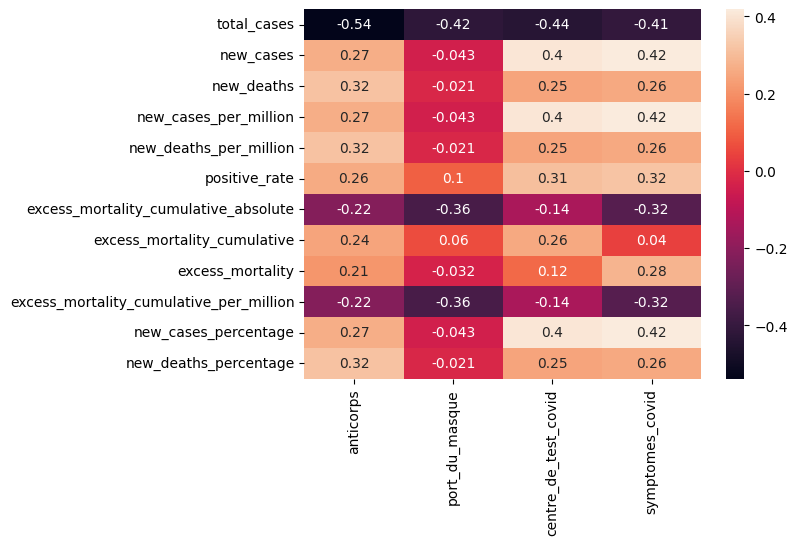

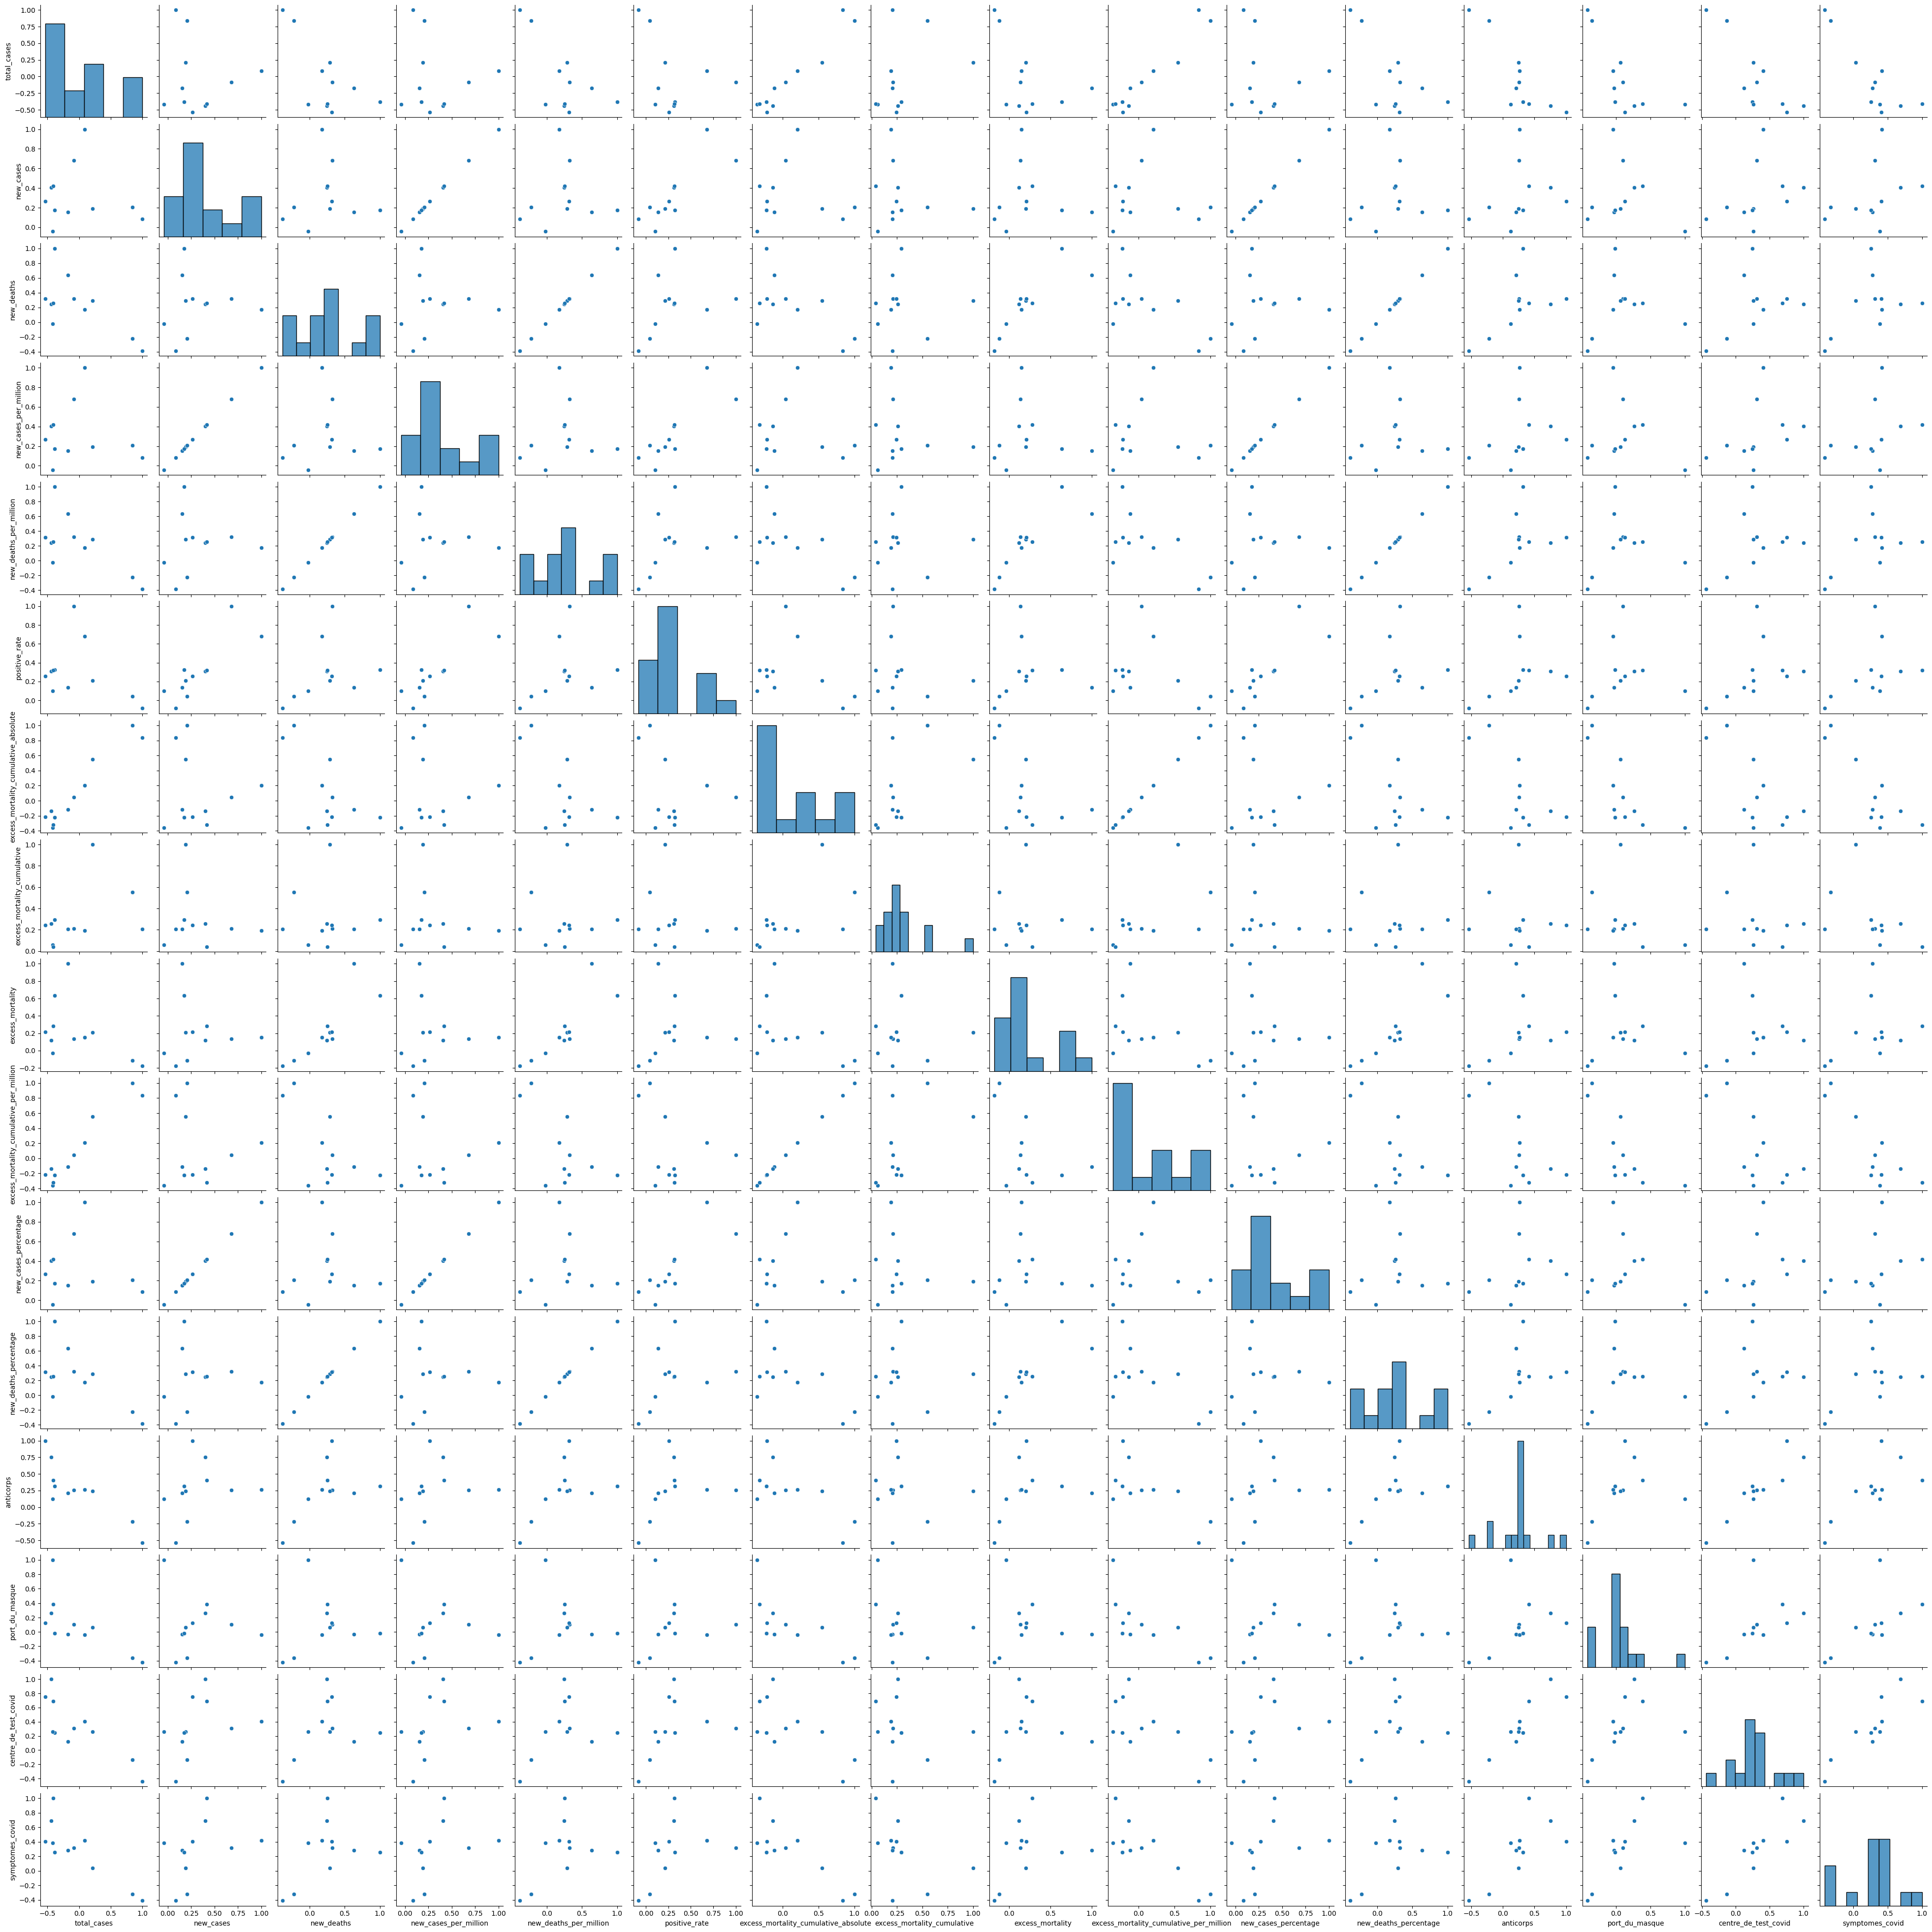

In [8]:
# Correlation_matrix
corr_matrix = merged_data.drop(['date'], axis=1).corr(method='pearson')
corr_matrix.to_csv('./data/cleaned_data/corr_matrix.csv', index=False) #saving correlation matrix to csv
correlation_matrix = corr_matrix.loc[:'new_deaths_percentage', 'anticorps':] #selecting only the correlations between covid and google trends

print(correlation_matrix)
#print(pd.DataFrame(np.array(correlation_matrix))) #printing correlation matrix in a more compact format

# Correlogram
sns.heatmap(correlation_matrix, annot=True) #selecting only the correlations between covid and google trends
sns.pairplot(corr_matrix)
plt.show()

Apart from looking at the correlation matrix, we also decided to compare the keywords anticorps, port du masque, centre de test covid, symptômes covid visually on a graph against new cases of covid in the same time.

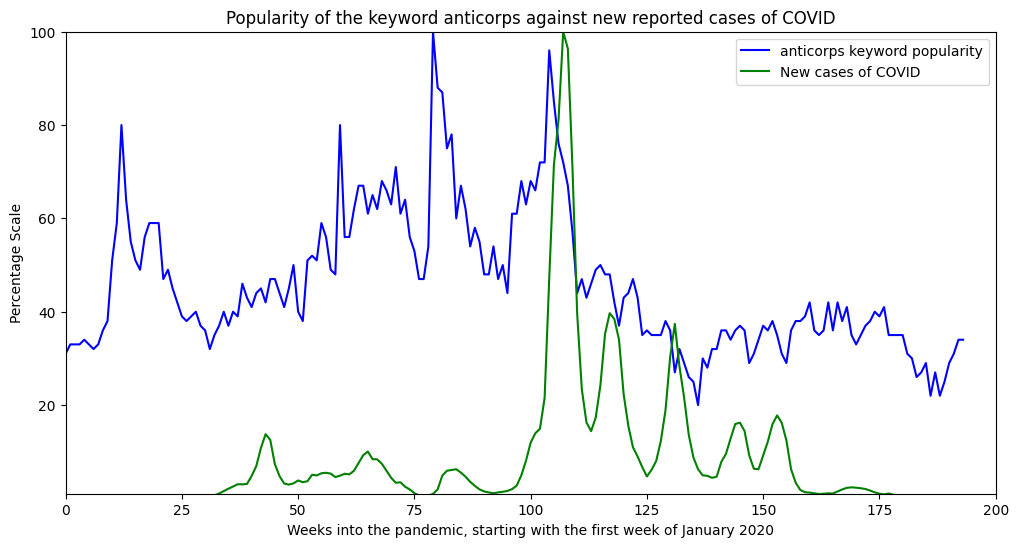

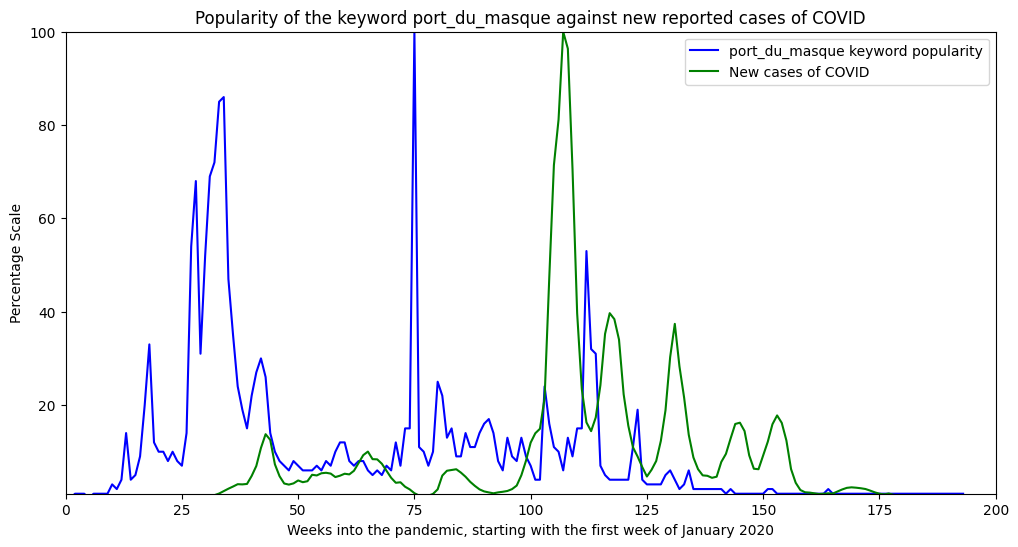

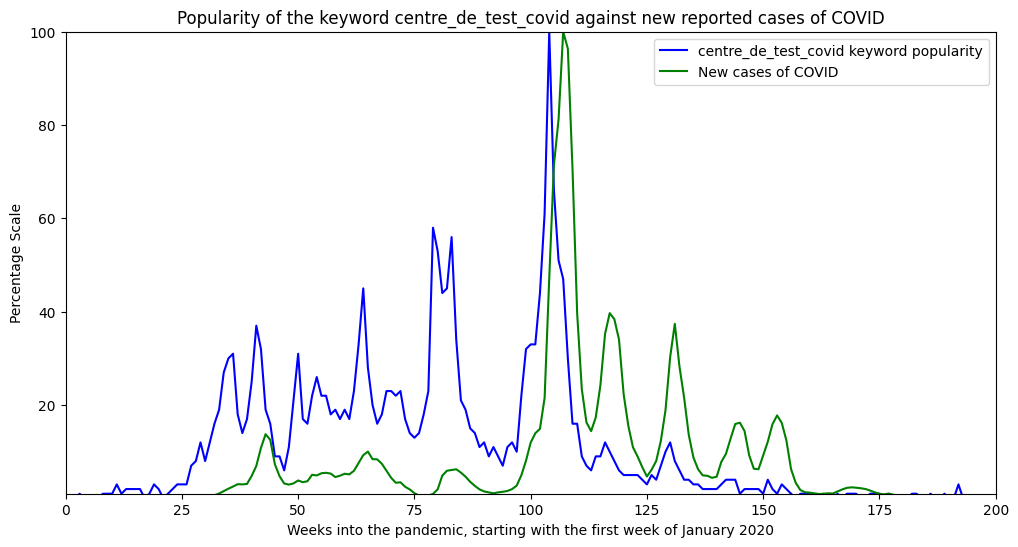

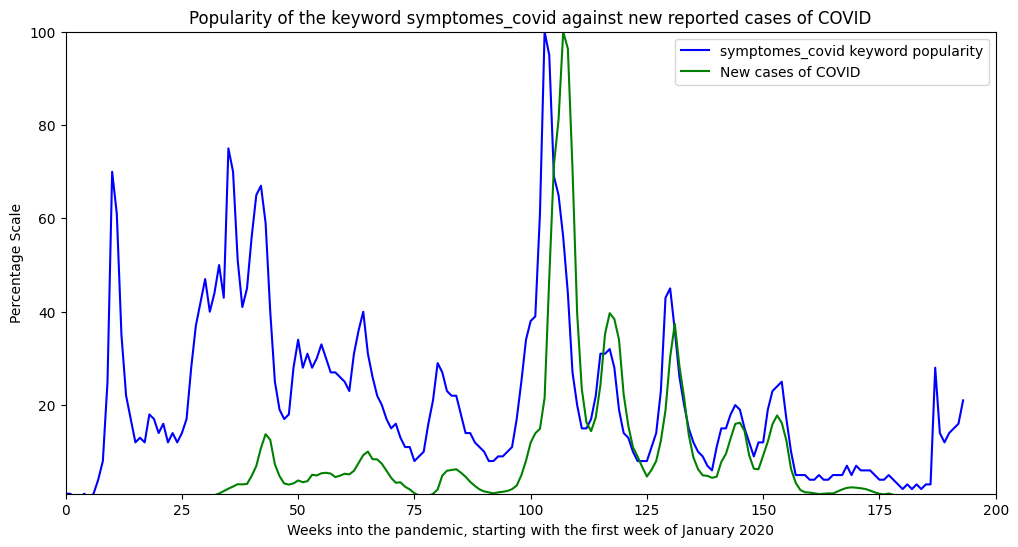

In [9]:
for key, val in keywords.items():
    plt.figure(figsize=(12, 6))
    plt.plot(val.index, val[key], label=f'{key} keyword popularity', color='blue')
    plt.plot(np.arange(weekly_covid_france.shape[0]), weekly_covid_france['new_cases_percentage'], label='New cases of COVID', color='green')
    plt.yscale('linear')
    plt.ylim(1, 100)
    plt.xlim([0, 200])
    plt.xlabel('Weeks into the pandemic, starting with the first week of January 2020')
    plt.ylabel('Percentage Scale')
    plt.title(f'Popularity of the keyword {key} against new reported cases of COVID')
    plt.legend()
    plt.show()

Finding the keyword with the best correlation

In [10]:
pop_key = correlation_matrix.idxmax(axis=1).mode()[0] #selecting the keyword with the best correlation
popular = merged_data[pop_key].to_frame()
print(f'The most correlated keyword is: {pop_key}')
print(popular.head())

The most correlated keyword is: symptomes_covid
   symptomes_covid
0                1
1                1
2                0
3                0
4                1


<span> Estimating if a wave is on. </span>

R is the average number of people infected by a single infectious individual. When R>1, the number of cases increases, and when R<1 the number of cases decreases. 

If R is significantly larger than 1 for an arbitrary period like two weeks, we identify that time period as a covid wave. Below, we take significantly larger than 1 to be 1.5, hence minR = 1.5, the period n = 2 weeks or 14 days.

Previously, we found what keywords correlate best with the actual new cases during the pandemic. For France, it was "symptômes covid", referred to as symptomes_covid. We treat the popularity of the keyword as a predictor of the number of new cases, and show on a graph where it overlaps with actual covid waves.

We use vertical spans to show when a keyword or the number of cases indicate a covid wave (recommend seeing the graph below first.)

In [11]:
n = 2
minR = 1.5

#spans indicate what areas in the timeline of the pandemic can be marked as times of covid waves.
spans_popular_keyword = [] 
spans_weekly_france = []
pct_col = weekly_covid_france.columns.get_loc('new_cases_percentage') #get index of column

# Iterate through the data to check when waves occur by the number of new cases (in percentage, which is probably imperfect.)
# We do it by treating it as a a number of new infections and finding R.
# Iterate through the data to check when waves occur according to the keyword symptomes_covid
# We do it by finding R.
for row in range(len(weekly_covid_france) - n):
    R1 = weekly_covid_france.iloc[row + n, pct_col] / weekly_covid_france.iloc[row, pct_col]
    R2 = (popular.iloc[row + n] / popular.iloc[row])[0]
    if R1 > minR and weekly_covid_france.iloc[row + n, pct_col]>3:
        spans_weekly_france.append((row, row + n))
    if R2 > minR and popular.iloc[row + n][0]>3:
        spans_popular_keyword.append((row, row + n))
        
print(spans_weekly_france)
print(spans_popular_keyword)

[(38, 40), (39, 41), (40, 42), (41, 43), (62, 64), (79, 81), (80, 82), (96, 98), (97, 99), (98, 100), (99, 101), (101, 103), (102, 104), (103, 105), (104, 106), (113, 115), (114, 116), (115, 117), (125, 127), (126, 128), (127, 129), (128, 130), (129, 131), (139, 141), (140, 142), (141, 143), (142, 144), (149, 151), (150, 152)]
[(5, 7), (6, 8), (7, 9), (8, 10), (9, 11), (25, 27), (26, 28), (34, 36), (47, 49), (48, 50), (61, 63), (76, 78), (77, 79), (78, 80), (95, 97), (96, 98), (97, 99), (98, 100), (100, 102), (101, 103), (102, 104), (113, 115), (125, 127), (126, 128), (127, 129), (128, 130), (138, 140), (139, 141), (149, 151), (150, 152), (185, 187), (186, 188)]


Function for combining overlapping spans (not necessary to understand the idea)

In [12]:
def combine_overlapping_spans(spans):
    if not spans:
        return []

    # Sort the spans by their start position
    sorted_spans = sorted(spans, key=lambda span: span[0])
    
    combined_spans = [sorted_spans[0]]

    for current_span in sorted_spans[1:]:
        previous_span = combined_spans[-1]

        if current_span[0] <= previous_span[1]:
            # Overlapping spans, update the end position of the previous span
            previous_span = (previous_span[0], max(previous_span[1], current_span[1]))
            combined_spans[-1] = previous_span
        else:
            # Non-overlapping span, add it to the combined_spans
            combined_spans.append(current_span)

    return combined_spans

Graphing covid waves (spans) indicated by new cases and by the keyword symptomes_covid

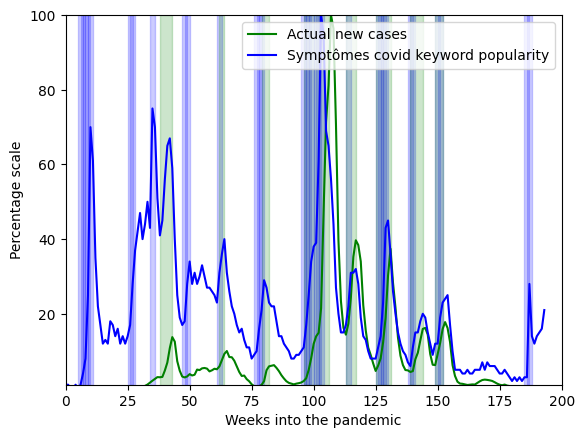

In [13]:
# Plot the data
plt.plot(np.arange(weekly_covid_france.shape[0]), weekly_covid_france['new_cases_percentage'], label='Actual new cases', color='green')
plt.plot(popular.index, popular[pop_key], label=f'Symptômes covid keyword popularity', color='blue')
plt.yscale('linear')
plt.ylim(1, 100)
plt.xlim([0, 200])
plt.xlabel('Weeks into the pandemic')
plt.ylabel('Percentage scale')
plt.legend()


combined_spans_covid = combine_overlapping_spans(spans_popular_keyword)
combined_spans_weekly_france = combine_overlapping_spans(spans_weekly_france)

# Add the background spans indicating covid waves
for span in spans_popular_keyword:
    plt.axvspan(span[0], span[1], color='blue', alpha=0.2)

for span in combined_spans_weekly_france:
    plt.axvspan(span[0], span[1], color='green', alpha=0.2)

plt.show()

As can be seen on the above graph, after actual cases started being reported (after week 25), blue spans usually precede green spans. This shows that the keyword can inform us that a covid wave is coming!

<span>Calculating overlap between covid waves indicated by the keyword "symptômes covid" and new cases</span>

In [14]:
def calculate_overlap_percentage(span_list1, span_list2):
    # Initialize variables to store the total overlap width and total width
    total_overlap_width = 0
    total_width = 0

    # Iterate through the spans in the first list
    for span1 in span_list1:
        start1, end1 = span1

        # Iterate through the spans in the second list
        for span2 in span_list2:
            start2, end2 = span2

            # Find the maximum of the start positions and the minimum of the end positions
            overlap_start = max(start1, start2)
            overlap_end = min(end1, end2)

            # Calculate the width of the overlap
            overlap_width = max(0, overlap_end - overlap_start)

            # Update the total overlap width and total width
            total_overlap_width += overlap_width
            total_width += max(end1, end2) - min(start1, start2)

    if total_width == 0:
        overlap_percentage = 0
    else:
        # Calculate the overlap as a percentage
        overlap_percentage = (total_overlap_width / total_width) * 100.0

    return overlap_percentage

print(calculate_overlap_percentage(spans_popular_keyword, spans_weekly_france))

0.10206123674204523


At only 10%, the overlap is small, but analysing the graph from before we can see, that the keyword can inform us about a covid wave in advance.

To find if a covid wave is about to occur, we could:
-use google trends to download the interest of a keyword in the last two weeks
-take the popularity of a keyword now and divide it by its popularity two weeks ago
-if we get >1.5, it's likely that a new covid wave is near

Accuracy score: 0.20871384788334357
Mean Squared Error: 104168804792.49031
R-squared (R2): 0.20871384788334357


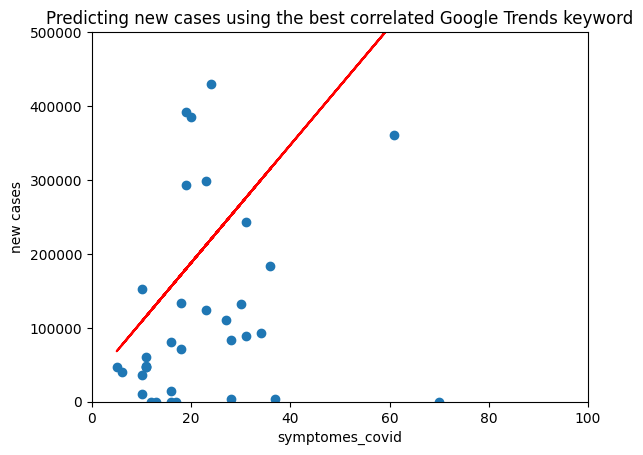

In [15]:
# Linear Regression model
#X = merged_data[['popular']] 
X = popular 
y = merged_data[['new_cases']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

# Create the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score = model.score(X_test, y_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print(f'Accuracy score: {accuracy_score}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')

# Plotting the results
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red') # regression line
plt.ylim(0, 500000)
plt.xlim(0, 100)
plt.xlabel(pop_key)
plt.ylabel('new cases')
plt.title('Predicting new cases using the best correlated Google Trends keyword')
plt.show()

After selecting the country by filtering the official Covid data and reading in the google keywords at the beginning of the file, we have the code pipeline the whole process towards the end with the wave prediction and linear regression model accuracy.